In [1]:
%matplotlib inline  

import pandas as pd
import numpy as np
import pandas_highcharts.core
from sqlalchemy import create_engine
import psycopg2
import matplotlib.pyplot 

#import datetime 
from datetime import datetime, date, timedelta

from isoweek import Week

import os

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "IMAM.settings")

from django.conf import settings
from home.management.commands.load_data import rename_cols, assign_state_lga_num

import django
django.setup()

from home.models import Stock, Site

In [2]:
engine = create_engine(
    'postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{NAME}'.format(**settings.DATABASES['default']))
df = pd.read_sql_query("select * from stock;", con=engine)

In [190]:
df.head()

,index,contact_uuid,urn,name,groups,siteid,first_seen,last_seen,weeknum,year,rutf_in,rutf_used_carton,rutf_used_sachet,rutf_bal_carton,rutf_bal_sachet,f75_bal_carton,f75_bal_sachet,f100_bal_carton,f100_bal_sachet,type
0,356919933,37953e19-a15b-486f-b540-fe4bda579414,+2347035432969,Liti Nuhu.,,1940110003,2016-11-02 15:21:57.473048+01:00,2016-11-02 15:30:49.667305+01:00,36,2016,30.0,20.0,80.0,60.0,16.0,NaN,NaN,NaN,NaN,OTP
1,428595444,729cdead-65f6-410a-aa27-5f02ec352cff,+2347033311675,Abdullahi Zubairu.,,2004110034,2017-02-09 11:46:12.559349+01:00,2017-02-09 11:54:45.917427+01:00,6,2017,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,OTP
2,432291171,75922589-9b7c-46cf-9dfd-54d606c42a89,+2348086487183,Mohammed Hussaini.,,837110010,2017-02-19 18:42:05.395577+01:00,2017-02-19 18:49:20.223206+01:00,3,2017,34.0,7.0,74.0,27.0,8.0,NaN,NaN,NaN,NaN,OTP
3,356919914,2dc00036-fc9b-4b21-8634-26e00e481743,+2348036832379,Binta Rabo.,,2016110029,2016-11-02 15:21:37.376357+01:00,2016-11-02 15:29:15.100709+01:00,36,2016,50.0,42.0,56.0,7.0,94.0,NaN,NaN,NaN,NaN,OTP
4,407944698,c6229de2-68b3-4fea-9e26-e2cd90f064ff,+2348020762648,Fati Baba Gana.,,816110028,2017-01-09 11:55:05.538947+01:00,2017-01-09 12:00:41.311426+01:00,52,2016,0.0,3.0,145.0,37.0,35.0,NaN,NaN,NaN,NaN,OTP


In [191]:
# Missing data for weeknum
print sorted(df.weeknum.unique())[0:5]
#df.weeknum.value_counts()

# Still week number 53 is included.
# it is deleted below in data cleaning

[1, 2, 3, 4, 5]


In [ ]:
# Make sure that supervision staff can submit reports for sites. 

In [2]:
# Do not need to import data when it is directly available from postgres

# df = pd.ExcelFile('/home/robert/Downloads/sto.xlsx').parse('Runs')


In [5]:
# rename_cols(df)

In [32]:
df.keys()

Index([u'index', u'contact_uuid', u'urn', u'name', u'groups', u'siteid',
       u'first_seen', u'last_seen', u'weeknum', u'year', u'rutf_in',
       u'rutf_used_carton', u'rutf_used_sachet', u'rutf_bal_carton',
       u'rutf_bal_sachet', u'f75_bal_carton', u'f75_bal_sachet',
       u'f100_bal_carton', u'f100_bal_sachet', u'type'],
      dtype='object')

In [3]:
df['siteid'] = pd.to_numeric(df.siteid, errors='coerce')
df['weeknum'] = pd.to_numeric(df.weeknum, errors='coerce')
df['rutf_bal_carton'] = pd.to_numeric(df.rutf_bal_carton, errors='coerce')
df['rutf_bal_sachet'] = pd.to_numeric(df.rutf_bal_sachet, errors='coerce')

df = df.query('siteid==siteid').query('0<siteid<3999990999')
# 2015 had 53 weeks
# 2016 had 52 weeks - current data is only for weeknumbers from 22-2016 to present
df = df.query('weeknum==weeknum').query('0.99<weeknum<53')
df = df.query('rutf_bal_carton==rutf_bal_carton').query('0<=rutf_bal_carton<9999')
df = df.query('rutf_bal_sachet==rutf_bal_sachet').query('0<=rutf_bal_sachet<9999')

df['siteid'] = df.siteid.astype('int')
df['weeknum'] = df.weeknum.astype('int')
df['rutf_bal_carton'] = df.rutf_bal_carton.astype('int')
df['rutf_bal_sachet'] = df.rutf_bal_sachet.astype('int')

In [4]:
len(df)

28395

In [194]:
# Drop unvalidated data
# df = df.query('confirm=="Yes"')

# all unvalidated data are not imported

In [5]:
# all duplicates should have been dropped in importation
# check if this is correct - did we forget type in importation? 

# Before filter - Sort data
df = df.sort_values(by='last_seen', ascending = False)
df = df.drop_duplicates(['siteid', 'weeknum', 'type','year'], keep ='first')

len(df)

28394

In [6]:
df['year_weeknum'] = zip(df['year'], df['weeknum'])

#the variable 'iso_year_weeknum' is an isoweek object
df['iso_year_weeknum'] = df['year_weeknum'].map(lambda x: Week(x[0], x[1]))

year, week, _ = date.today().isocalendar()
current_week = Week(year, week)

# Number of weeks from current week until report week (weeknum)
df['since_x_weeks'] = df['iso_year_weeknum'].map(lambda x: current_week - x)

In [7]:
df = df.query('not (weeknum < 22 & year <=2016)')
df = df.query('not (weeknum > %s & year ==%s)' % (week, year)) 
df = df.query('year >= 2016')

In [8]:
# Year is added and corrected in importation
df['year'].value_counts()

2016    13922
2017    13893
Name: year, dtype: int64

In [166]:
# are year_weeknum and iso_year_weeknum the same? 
#df.plot.scatter('year_weeknum', 'iso_year_weeknum')

print (df['year_weeknum']) == (df['iso_year_weeknum'])

#First is tuple, second is isocalendar object
print type(df['year_weeknum'])
print type(df['iso_year_weeknum'])

13727    True
25629    True
6626     True
7940     True
7942     True
1163     True
7972     True
1178     True
24856    True
1204     True
1260     True
1271     True
7372     True
1275     True
8269     True
1738     True
6440     True
398      True
1668     True
4973     True
6128     True
6944     True
4937     True
25623    True
6911     True
4930     True
651      True
428      True
6865     True
233      True
         ... 
15576    True
15621    True
13711    True
20559    True
13411    True
19925    True
19921    True
19913    True
15923    True
19912    True
13650    True
15631    True
15629    True
13709    True
20082    True
15058    True
15074    True
15071    True
15069    True
18511    True
16428    True
20024    True
19922    True
12670    True
16427    True
10879    True
17124    True
13717    True
26133    True
17156    True
dtype: bool
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


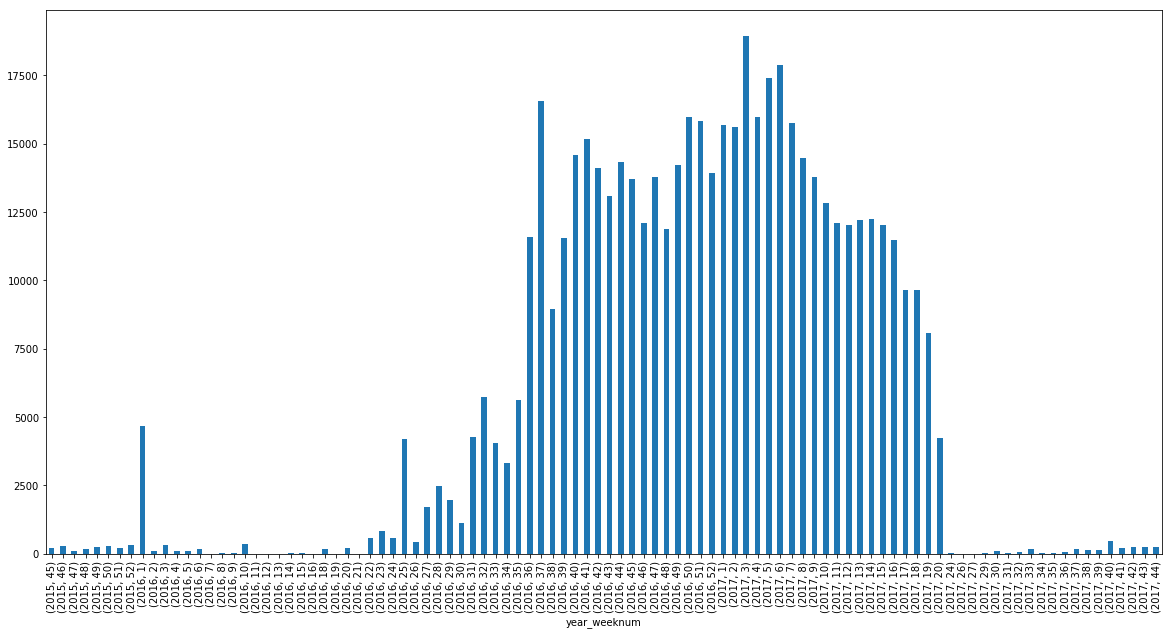

In [185]:
# review year_weeknum in table sorted by date

# all implementation level RUTF stock balance by week
stock_by_week = df['rutf_bal_carton'].groupby(df['year_weeknum']).sum().plot(kind = 'bar', figsize=(20,10))


# value counts is not easily sortable by date
#(df['year_weeknum'].value_counts().plot(kind = 'bar')

# sort data
#df = df.sort_values(by=['iso_year_weeknum'])    
    
#df['year_weeknum'].value_counts().plot(kind = 'bar')
# value counts always presents data as distribution sorted by number of counts

In [183]:
# For state and LGA queries
# Use LGA database
assign_state_lga_num(df)
df.lga_num.unique()


array(['3503', '3609', '812', '821', '513', '2010', '1712', '2109', '2004',
       '1940', '2112', '813', '3605', '816', '1823', '1921', '1905', '819',
       '208', '818', '2018', '218', '3313', '3513', '2011', '2034', '3317',
       '1719', '2104', '1805', '804', '2016', '1936', '3517', '212',
       '3504', '3514', '1704', '221', '3501', '814', '2027', '806', '3602',
       '2106', '802', '3301', '3319', '202', '3611', '1727', '805', '1710',
       '2113', '3305', '1714', '3308', '2026', '217', '3509', '3505',
       '2118', '3508', '2119', '825', '1944', '2115', '3510', '1606',
       '2001', '2105', '3502', '3304', '1724', '1801', '3511', '203',
       '1928', '2003', '512', '3306', '213', '1604', '827', '1716', '2117',
       '807', '3321', '2033', '220', '1703', '2015', '2108', '2114', '201',
       '206', '2103', '3607', '209', '210', '504', '3507', '1702', '809',
       '215', '2005', '1818', '2007', '1717', '3512', '3506', '3516',
       '207', '2111', '219', '2024', '3603', 

In [150]:
# LGA level stocks must use LGA stock df

# Calculate median stock use over time. 
stock_by_week = df.query('state_num==2')['rutf_bal_carton'].groupby(df['year_weeknum'])\
        .sum().plot(kind = 'bar', figsize=(20,10))

TypeError: Empty 'DataFrame': no numeric data to plot

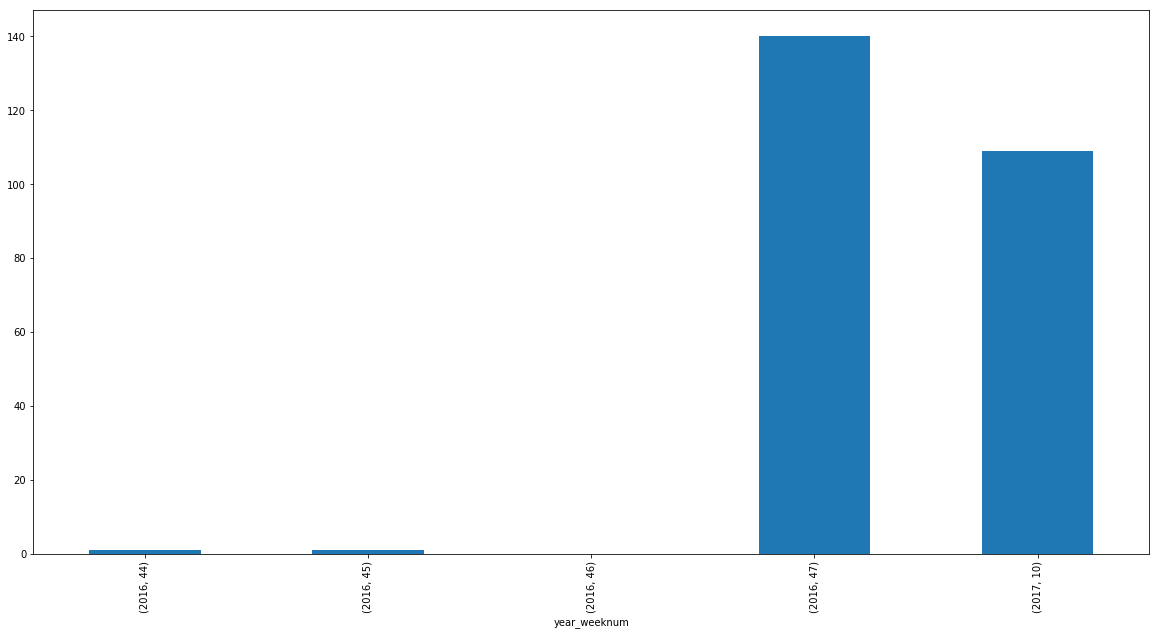

In [206]:
# For site level queries
stock_by_week = df.query('siteid==211110029 & type=="OTP"')['rutf_bal_carton'].groupby(df['year_weeknum']).sum().plot(kind = 'bar', figsize=(20,10))

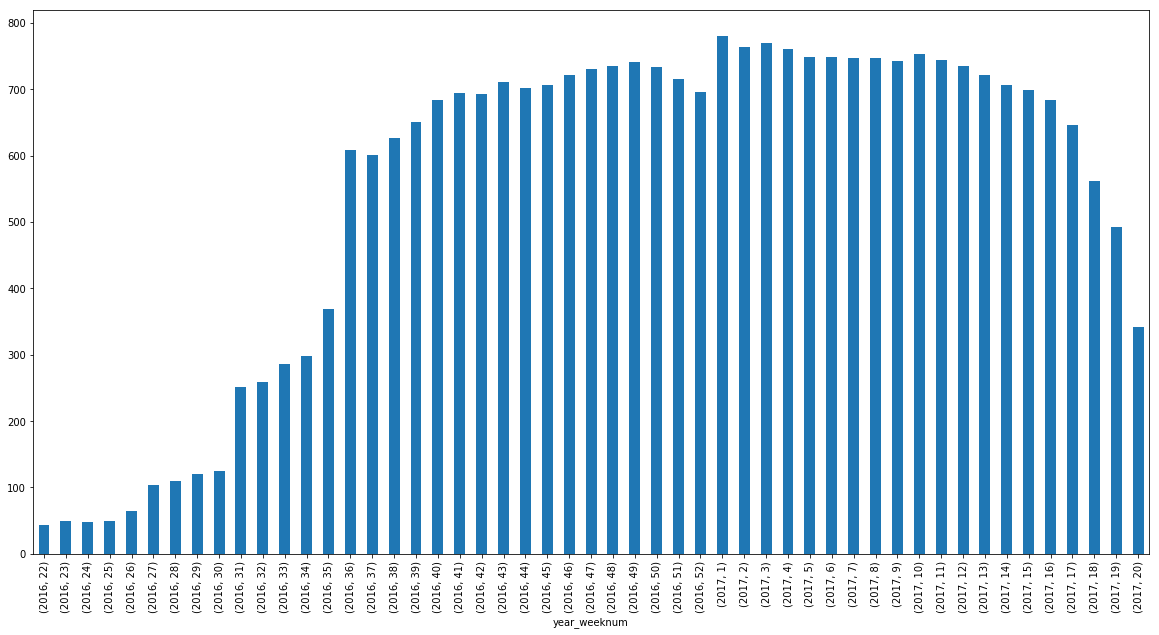

In [9]:
# sort data
df = df.sort_values(by=['since_x_weeks'])    

# Plot count of reports over year_weeknum
# Presents the counts of data received
report_counts = df['index'].groupby(df['year_weeknum']).count().plot(kind = 'bar', figsize=(20,10))

# significant missing data from week 50, 51, 52
# appears these data are incorrectly assigned to year 2017
# are these incorrect 2017 data all reported after weeknumber 8 in year 2017? 

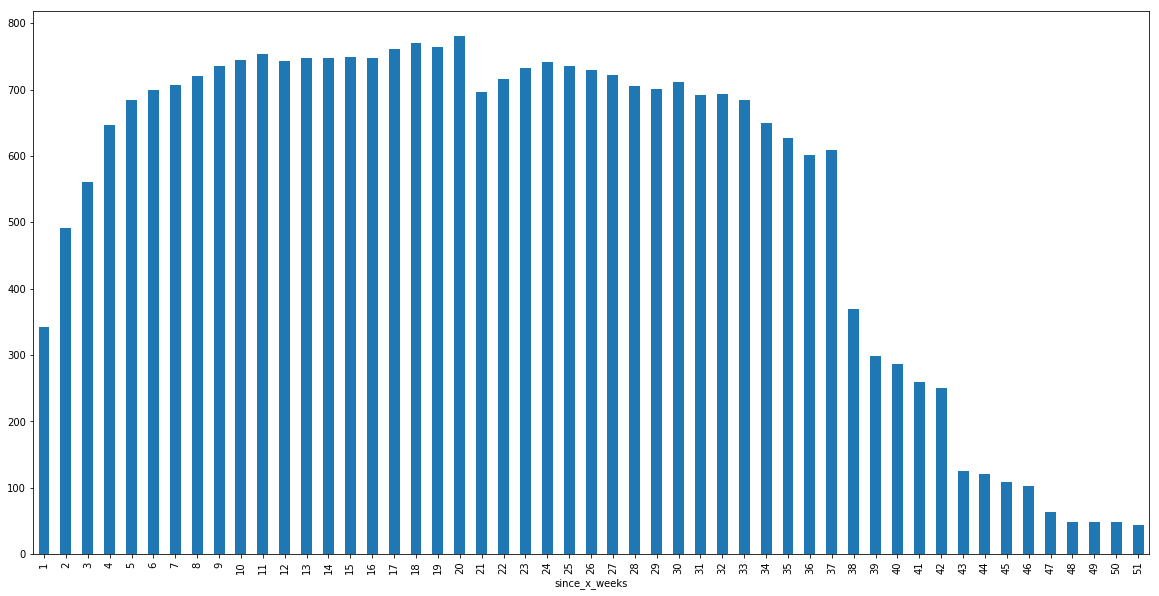

In [10]:
df['index'].groupby(df['since_x_weeks']).count().plot(kind = 'bar', figsize=(20,10))



In [11]:
# What is the median stock consumption over past 8 weeks

df['since_x_weeks'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51])

In [26]:
max_since_x_weeks = df['since_x_weeks'].max()

result = {
    'rutf_used_carton': [],
    'isoweek': [],
}

for i in sorted(df['since_x_weeks'].unique()):
    if i > (max_since_x_weeks - 7):
        break
    # XXX do we need to break before the end because we move on a window of * weeks?
    result['rutf_used_carton'].append(df.query('since_x_weeks >= %s & since_x_weeks < (%s + 8)' % (i, i))['rutf_used_carton'].median())
    result['isoweek'].append(df.query('since_x_weeks >= %s & since_x_weeks < (%s + 8)' % (i, i))['iso_year_weeknum'].max())

median_usage = pd.DataFrame(result)
median_usage
# print result


,isoweek,rutf_used_carton
0,"(2017, 20)",5.0
1,"(2017, 19)",5.0
2,"(2017, 18)",5.0
3,"(2017, 17)",5.0
4,"(2017, 16)",5.0
5,"(2017, 15)",5.0
6,"(2017, 14)",5.0
7,"(2017, 13)",5.0
8,"(2017, 12)",5.0
9,"(2017, 11)",5.0


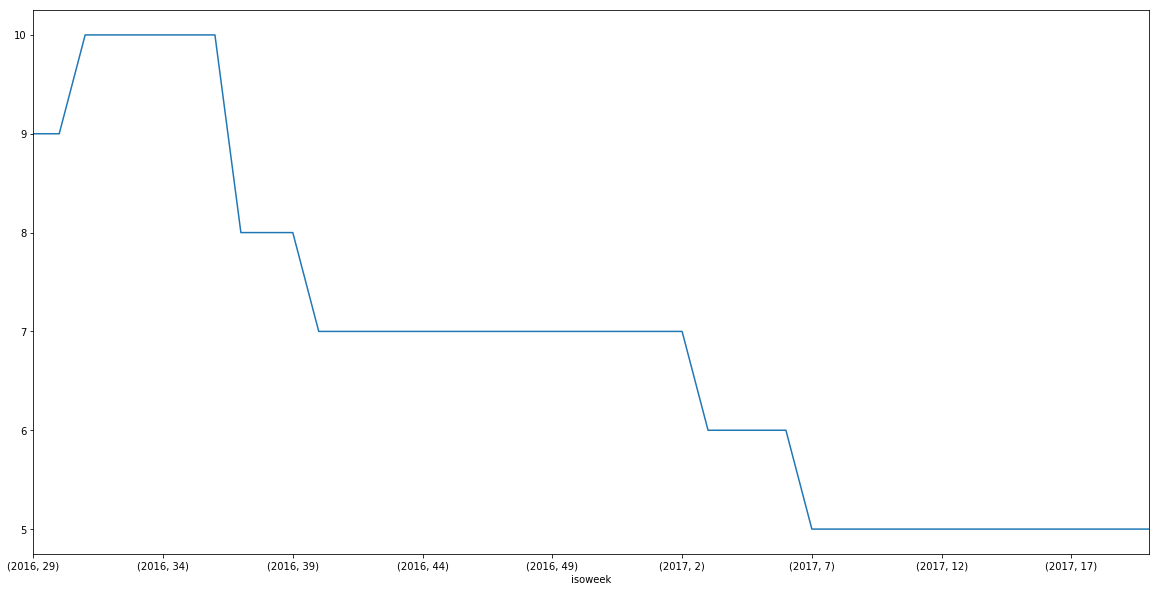

In [32]:
median_usage.groupby(['isoweek'])['rutf_used_carton'].max().plot(figsize=(20,10))

In [11]:
# Quantity of RUTF in last (most recent) stock report

sorted(df.query('year==2017').sort_values(by='weeknum', ascending = False).drop_duplicates(['siteid'], keep ='last')['rutf_bal_carton'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 46,
 47,
 48,
 49,
 50,
 51,
 53,
 54,
 55,
 56,
 57,
 58,
 60,
 62,
 63,
 66,
 67,
 68,
 69,
 70,
 71,
 74,
 77,
 79,
 81,
 84,
 85,
 86,
 91,
 94,
 95,
 96,
 103,
 109,
 112,
 118,
 123,
 127,
 130,
 133,
 140,
 150,
 174,
 175,
 180,
 181,
 183,
 258,
 269,
 499]

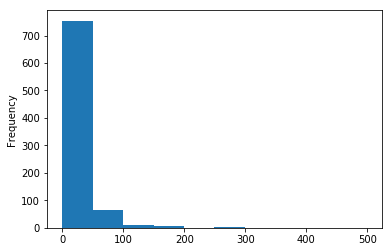

In [56]:
# most recent stock report for sites
df.query('year==2017').sort_values(by='weeknum', ascending = False).drop_duplicates(['siteid'],\
                keep ='last')['rutf_bal_carton'].plot.hist()

In [57]:
# most recent stock report for sites
print df.query('year==2017').query('siteid==3613110051').sort_values(by='weeknum', ascending = False).drop_duplicates(['siteid'], keep ='last')['rutf_bal_carton']
print df.query('year==2017').query('siteid==3613110051').sort_values(by='weeknum', ascending = False).drop_duplicates(['siteid'], keep ='last')['rutf_bal_sachet']

2853    24
Name: rutf_bal_carton, dtype: int64
2853    43
Name: rutf_bal_sachet, dtype: int64


In [58]:
 df.query('year==2017').query('siteid==3613110051').sort_values(by='weeknum', ascending = False).drop_duplicates(['siteid'], keep ='last')['rutf_bal_sachet']

2853    43
Name: rutf_bal_sachet, dtype: int64

In [59]:
 df.query('year==2017').query('siteid==3613110051').sort_values(by='weeknum', ascending = False).drop_duplicates(['siteid'], keep ='last')['weeknum']

2853    1
Name: weeknum, dtype: int64

In [60]:
import datetime as datetime

In [61]:
print datetime.datetime.now().strftime('Weekly reminders sent at %d %b %Y %-H:%M:%S')

Weekly reminders sent at 19 May 2017 17:57:35


In [62]:
print datetime.datetime.now().strftime('Weekly reminders sent at %c')
#print datetime.datetime.now()

Weekly reminders sent at Fri May 19 17:57:37 2017
